Import packages,
realize how we import keras from tensorflow 

`tensorflow.python.keras`

This is new in tensorflow version 1.4.0

In [2]:
from tensorflow.python.keras.applications.vgg16 import VGG16
from tensorflow.python.keras import models
from tensorflow.python.keras import layers
from tensorflow.python.keras.preprocessing import image
import tensorflow as tf
import numpy as np

import os
import shutil


tf.__version__

/Users/davehiltbrand/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


'1.5.0'

## Build Keras model
We are leveraging the pre-trained VGG16 model's convolution layers. aka the "convolutional base" of the model. Then we add our own classifier fully connected layers to do binary classification(cat vs dog). 

Note that since we don't want to touch the parameters pre-trained in the "convolutional base", so we set them as not trainable. Want to go deeper how this model works? Check out this great [jupyter notebook](https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/5.3-using-a-pretrained-convnet.ipynb) by the creator of Keras.

In [3]:
conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150,150,3))

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
conv_base.trainable = False

In [4]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 2,097,665
Non-trainable params: 14,714,688
_________________________________________________________________


In [5]:
model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])

Instructions for updating:
keep_dims is deprecated, use keepdims instead


## Keras model to TF estimator
`model_dir` will be our location to store trained tensorflow models. Training progress can be viewed by TensorBoard.

I found that I have to specify the full path, otherwise, Tensorflow will complain about it later during training.

In [7]:
model_dir = os.path.join(os.getcwd(), "models/morphVGG")
os.makedirs(model_dir, exist_ok=True)
print("model_dir: ",model_dir)
est_malevsfemale = tf.keras.estimator.model_to_estimator(keras_model=model,
                                                    model_dir=model_dir)

model_dir:  /Users/davehiltbrand/GitHub/DL/models/morphVGG
INFO:tensorflow:Using the Keras model from memory.


INFO:tensorflow:Using default config.


INFO:tensorflow:Using config: {'_model_dir': '/Users/davehiltbrand/GitHub/DL/models/morphVGG', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x181cf66320>, '_task_type': 'worker', '_task_id': 0, '_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


The input_name is the model's input layer name, we will need it later when building Input function for your estimator. More on that in Input function section below.

In [8]:
# input layer name
input_name = model.input_names
input_name

['vgg16_input']

## Downloading the data

The cats vs. dogs dataset was made available by Kaggle.com as part of a computer vision 
competition in late 2013. You can download the original dataset at 
https://www.kaggle.com/c/dogs-vs-cats/download/train.zip (you will need to create a Kaggle account if you don't already have one -- don't worry, the 
process is painless).

After downloading and uncompressing it, we will create a new dataset containing three subsets: a training set with 1000 samples of each class, and a test set with 500 samples of each class.

In [39]:
# The path to the directory where the original
# dataset was uncompressed
original_dataset_dir = './morph/images'

# The directory where we will
# store our smaller dataset
base_dir = './data/male_vs_female_small'
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')
train_male_dir = os.path.join(train_dir, 'male')
train_female_dir = os.path.join(train_dir, 'female')
test_male_dir = os.path.join(test_dir, 'male')
test_female_dir = os.path.join(test_dir, 'female')

In [18]:
os.makedirs(base_dir, exist_ok=True)
# Directories for our training,
# validation and test splits
os.mkdir(train_dir)
os.mkdir(test_dir)
# Directory with our training male pictures
os.mkdir(train_male_dir)
# Directory with our training female pictures
os.mkdir(train_female_dir)
# Directory with our validation male pictures
os.mkdir(test_male_dir)
# Directory with our validation female pictures
os.mkdir(test_female_dir)


In [8]:
import glob
images = glob.glob('morph/images/*.JPG')
train = images[0:750]
test = images[751:1000]
# Copy first 750 male images to train_male_dir
fnames = [i for i in train if 'M' in i]
for fname in fnames:
    _, tail = os.path.split(fname)
    src = os.path.join(original_dataset_dir, tail)
    dst = os.path.join(train_male_dir, tail)
    shutil.copyfile(src, dst)
# Copy first 750 male images to train_male_dir
fnames = [i for i in train if 'F' in i]
for fname in fnames:
    _, tail = os.path.split(fname)
    src = os.path.join(original_dataset_dir, tail)
    dst = os.path.join(train_female_dir, tail)
    shutil.copyfile(src, dst)
# Copy next 250 male images to test_male_dir
fnames = [i for i in test if 'M' in i]
for fname in fnames:
    _, tail = os.path.split(fname)
    src = os.path.join(original_dataset_dir, tail)
    dst = os.path.join(test_male_dir, tail)
    shutil.copyfile(src, dst)
# Copy next 250 female images to train_male_dir
fnames = [i for i in test if 'F' in i]
for fname in fnames:
    _, tail = os.path.split(fname)
    src = os.path.join(original_dataset_dir, tail)
    dst = os.path.join(test_female_dir, tail)
    shutil.copyfile(src, dst)


As a sanity check, let's count how many pictures we have in each training split (train/test):

In [40]:
print('total training male images:', len(os.listdir(train_male_dir)))
print('total training female images:', len(os.listdir(train_female_dir)))
print('total test male images:', len(os.listdir(test_male_dir)))
print('total test female images:', len(os.listdir(test_female_dir)))

total training male images: 563
total training female images: 189
total test male images: 187
total test female images: 62


In [41]:
print(train_male_dir)

./data/male_vs_female_small/train/male


Function to shuffle images along with the labels

In [42]:
def unison_shuffled_copies(a, b):
    a = np.array(a)
    b = np.array(b)
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

Collect and shuffle image files with associated labels.

In [43]:
MALE_LABEL = 0
FEMALE_LABEL = 1
train_male = [os.path.join(train_male_dir, file_name) for file_name in os.listdir(train_male_dir)]
train_female = [os.path.join(train_female_dir, file_name) for file_name in os.listdir(train_female_dir)]
train_files = train_male + train_female
train_labels = [MALE_LABEL]*len(train_male)+[FEMALE_LABEL]*len(train_female)
train_files, train_labels = unison_shuffled_copies(train_files, train_labels)
test_male = [os.path.join(test_male_dir, file_name) for file_name in os.listdir(test_male_dir)]
test_female = [os.path.join(test_female_dir, file_name) for file_name in os.listdir(test_female_dir)]
test_files = test_male + test_female
test_labels = [MALE_LABEL]*len(test_male)+[FEMALE_LABEL]*len(test_female)
test_files, test_labels = unison_shuffled_copies(test_files, test_labels)

Have a look at first 10 shuffled image files and labels.

In [44]:
print(test_files[:10])
print(train_labels[:10])

['./data/male_vs_female_small/test/male/254586_01M40.JPG'
 './data/male_vs_female_small/test/female/108101_0F33.JPG'
 './data/male_vs_female_small/test/female/166928_01F29.JPG'
 './data/male_vs_female_small/test/male/343075_01M32.JPG'
 './data/male_vs_female_small/test/female/247498_03F24.JPG'
 './data/male_vs_female_small/test/male/103743_3M37.JPG'
 './data/male_vs_female_small/test/male/275320_02M25.JPG'
 './data/male_vs_female_small/test/female/335180_02F23.JPG'
 './data/male_vs_female_small/test/male/324260_01M40.JPG'
 './data/male_vs_female_small/test/female/165370_02F32.JPG']
[0 1 0 0 0 0 0 0 0 0]


## Input function
When we train our model, we'll need a function that reads the input image files/labels and returns the image data and labels. Estimators require that you create a function of the following format:
````
def input_fn():
    ...<code>...
    return ({ 'input_1':[ImagesValues]},
            [ImageTypeLogit])
```
The return value must be a two-element tuple organized as follows: :

- The first element must be a dictionary in which each input feature is a key, and then a list of values for the training batch.
- The second element is a list of labels for the training batch.
### Arguments
- **filenames**, an array of image file names
- **labels=None**, an array of the image labels for the model. Set to None for inference
- **perform_shuffle=False**, useful when training, reads batch_size records, then shuffles (randomizes) their order.
- **repeat_count=1**, useful when training, repeat the input data several times for each epoch
- **batch_size=1**, reads batch_size records at a time

In [45]:
def imgs_input_fn(filenames, labels=None, perform_shuffle=False, repeat_count=1, batch_size=1):
    def _parse_function(filename, label):
        image_string = tf.read_file(filename)
        image = tf.image.decode_image(image_string, channels=3)
        image.set_shape([None, None, None])
        image = tf.image.resize_images(image, [150, 150])
        image = tf.subtract(image, 116.779) # Zero-center by mean pixel
        image.set_shape([150, 150, 3])
        image = tf.reverse(image, axis=[2]) # 'RGB'->'BGR'
        d = dict(zip([input_name], [image])), label
        return d
    if labels is None:
        labels = [0]*len(filenames)
    labels = np.array(labels)
    # Expand the shape of "labels" if necessory
    if len(labels.shape) == 1:
        labels = np.expand_dims(labels, axis=1)
    filenames = tf.constant(filenames)
    labels = tf.constant(labels)
    labels = tf.cast(labels, tf.float32)
    dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
    dataset = dataset.map(_parse_function)
    if perform_shuffle:
        # Randomizes input using a window of 256 elements (read into memory)
        dataset = dataset.shuffle(buffer_size=256)
    dataset = dataset.repeat(repeat_count)  # Repeats dataset this # times
    dataset = dataset.batch(batch_size)  # Batch size to use
    iterator = dataset.make_one_shot_iterator()
    batch_features, batch_labels = iterator.get_next()
    return batch_features, batch_labels


## Look at the input function output
Looks like color channels 'RGB' has changed to 'BGR' and shape resized to (150, 150) correctly for our model. That is the input format the VGG16's "convolutional base" is expecting.

(20, 150, 150, 3)


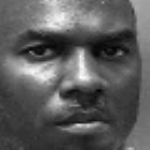

In [46]:
next_batch = imgs_input_fn(test_files, labels=test_labels, perform_shuffle=True, batch_size=20)
with tf.Session() as sess:
    first_batch = sess.run(next_batch)
x_d = first_batch[0]['vgg16_input']

print(x_d.shape)
img = image.array_to_img(x_d[8])
img

Here is the first batch's labels.

In [28]:
first_batch[1]

array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.]], dtype=float32)

## Training the model
Estimators require an `input_fn` with no arguments, so we create a function with no arguments using lambda. Suggested you should only attempt it if you have access to a GPU, it only takes couple minutes.

In [32]:
# Train our model, use the previously function imgs_input_fn
# Input to training is a file with training example
# Stop training after "repeat_count" iterations of train data (epochs)
est_malevsfemale.train(
   input_fn=lambda: imgs_input_fn(test_files,
                                  labels=test_labels,
                                  perform_shuffle=True,
                                  repeat_count=5,
                                  batch_size=20))

INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Restoring parameters from /Users/davehiltbrand/GitHub/DL/models/morphVGG/model.ckpt-3


INFO:tensorflow:Saving checkpoints for 4 into /Users/davehiltbrand/GitHub/DL/models/morphVGG/model.ckpt.


INFO:tensorflow:loss = 0.5658845, step = 4


KeyboardInterrupt: 

## Evaluate
Evaluate our model using the examples contained in test_files and test_labels

Return value will contain evaluation_metrics such as: loss & average_loss

In [71]:
evaluate_results = est_malevsfemale.evaluate(
    input_fn=lambda: imgs_input_fn(test_files, 
                                   labels=test_labels, 
                                   perform_shuffle=False,
                                   batch_size=1))
print("Evaluation results")
for key in evaluate_results:
    print("   {}, was: {}".format(key, evaluate_results[key]))

INFO:tensorflow:Starting evaluation at 2018-03-15-22:04:24


INFO:tensorflow:Restoring parameters from /Users/davehiltbrand/GitHub/DL/models/morph/model.ckpt-320


INFO:tensorflow:Finished evaluation at 2018-03-15-22:05:11


INFO:tensorflow:Saving dict for global step 320: acc = 1.0, global_step = 320, loss = 1.1003451e-07


Evaluation results
   acc, was: 1.0
   loss, was: 1.1003451305668932e-07
   global_step, was: 320


## Predict
To predict we can set the `labels` to None because that is what we will be predicting.

Here we only predict the first 10 images in the test_files.

In [77]:
predict_results = est_malevsfemale.predict(
    input_fn=lambda: imgs_input_fn(test_files[:10], 
                                   labels=None, 
                                   perform_shuffle=False,
                                   batch_size=10))

In [78]:
predict_logits = []
for prediction in predict_results:
    predict_logits.append(prediction['dense_5'][0])

INFO:tensorflow:Restoring parameters from /Users/davehiltbrand/GitHub/DL/models/morph/model.ckpt-320


### Check the prediction result
The model correctly classified all 10 images.

In [79]:
predict_is_male = [logit > 0.5 for logit in predict_logits]
actual_is_female = [label > 0.5 for label in test_labels[:10]]
print("Predict male:",predict_is_male)
print("Actual female:",actual_is_female)

Predict male: [True, False, False, True, False, False, True, True, False, False]
Actual female: [True, False, False, True, False, False, True, True, False, False]


### tf.estimator.train_and_evaluate

TensorFlow release 1.4 also introduces the utility function **tf.estimator.train_and_evaluate**, which simplifies training, evaluation, and exporting Estimator models. This function enables distributed execution for training and evaluation, while still supporting local execution.

Notice that the train was build on previous training result when we call the `est_catvsdog.train()`

In [80]:
train_spec = tf.estimator.TrainSpec(input_fn=lambda: imgs_input_fn(test_files,
                                                                   labels=test_labels,
                                                                   perform_shuffle=True,
                                                                   repeat_count=5,
                                                                   batch_size=20), 
                                    max_steps=500)
eval_spec = tf.estimator.EvalSpec(input_fn=lambda: imgs_input_fn(test_files,
                                                                 labels=test_labels,
                                                                 perform_shuffle=False,
                                                                 batch_size=1))
import time
start_time = time.time()
tf.estimator.train_and_evaluate(est_malevsfemale, train_spec, eval_spec)
print("--- %s seconds ---" % (time.time() - start_time))

INFO:tensorflow:Running training and evaluation locally (non-distributed).


INFO:tensorflow:Start train and evaluate loop. The evaluate will happen after 600 secs (eval_spec.throttle_secs) or training is finished.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Restoring parameters from /Users/davehiltbrand/GitHub/DL/models/morph/model.ckpt-320


INFO:tensorflow:Saving checkpoints for 321 into /Users/davehiltbrand/GitHub/DL/models/morph/model.ckpt.


INFO:tensorflow:loss = 1.2246275e-07, step = 321


INFO:tensorflow:Saving checkpoints for 371 into /Users/davehiltbrand/GitHub/DL/models/morph/model.ckpt.


INFO:tensorflow:Loss for final step: 1.04802346e-07.


INFO:tensorflow:Starting evaluation at 2018-03-15-22:30:00


INFO:tensorflow:Restoring parameters from /Users/davehiltbrand/GitHub/DL/models/morph/model.ckpt-371


INFO:tensorflow:Evaluation [10/100]


INFO:tensorflow:Evaluation [20/100]


INFO:tensorflow:Evaluation [30/100]


INFO:tensorflow:Evaluation [40/100]


INFO:tensorflow:Evaluation [50/100]


INFO:tensorflow:Evaluation [60/100]


INFO:tensorflow:Evaluation [70/100]


INFO:tensorflow:Evaluation [80/100]


INFO:tensorflow:Evaluation [90/100]


INFO:tensorflow:Evaluation [100/100]


INFO:tensorflow:Finished evaluation at 2018-03-15-22:30:20


INFO:tensorflow:Saving dict for global step 371: acc = 1.0, global_step = 371, loss = 1.0537855e-07


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Restoring parameters from /Users/davehiltbrand/GitHub/DL/models/morph/model.ckpt-371


INFO:tensorflow:Saving checkpoints for 372 into /Users/davehiltbrand/GitHub/DL/models/morph/model.ckpt.


INFO:tensorflow:loss = 1.04802346e-07, step = 372


INFO:tensorflow:Saving checkpoints for 426 into /Users/davehiltbrand/GitHub/DL/models/morph/model.ckpt.


INFO:tensorflow:Loss for final step: 1.0384188e-07.


INFO:tensorflow:Starting evaluation at 2018-03-15-22:40:26


INFO:tensorflow:Restoring parameters from /Users/davehiltbrand/GitHub/DL/models/morph/model.ckpt-426


INFO:tensorflow:Evaluation [10/100]


INFO:tensorflow:Evaluation [20/100]


INFO:tensorflow:Evaluation [30/100]


INFO:tensorflow:Evaluation [40/100]


INFO:tensorflow:Evaluation [50/100]


INFO:tensorflow:Evaluation [60/100]


INFO:tensorflow:Evaluation [70/100]


INFO:tensorflow:Evaluation [80/100]


INFO:tensorflow:Evaluation [90/100]


INFO:tensorflow:Evaluation [100/100]


INFO:tensorflow:Finished evaluation at 2018-03-15-22:40:45


INFO:tensorflow:Saving dict for global step 426: acc = 1.0, global_step = 426, loss = 1.0537855e-07


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Restoring parameters from /Users/davehiltbrand/GitHub/DL/models/morph/model.ckpt-426


INFO:tensorflow:Saving checkpoints for 427 into /Users/davehiltbrand/GitHub/DL/models/morph/model.ckpt.


INFO:tensorflow:loss = 1.0384188e-07, step = 427


INFO:tensorflow:Saving checkpoints for 481 into /Users/davehiltbrand/GitHub/DL/models/morph/model.ckpt.


INFO:tensorflow:Loss for final step: 1.0384188e-07.


INFO:tensorflow:Starting evaluation at 2018-03-15-22:50:54


INFO:tensorflow:Restoring parameters from /Users/davehiltbrand/GitHub/DL/models/morph/model.ckpt-481


INFO:tensorflow:Evaluation [10/100]


INFO:tensorflow:Evaluation [20/100]


INFO:tensorflow:Evaluation [30/100]


INFO:tensorflow:Evaluation [40/100]


INFO:tensorflow:Evaluation [50/100]


INFO:tensorflow:Evaluation [60/100]


INFO:tensorflow:Evaluation [70/100]


INFO:tensorflow:Evaluation [80/100]


INFO:tensorflow:Evaluation [90/100]


INFO:tensorflow:Evaluation [100/100]


INFO:tensorflow:Finished evaluation at 2018-03-15-22:51:14


INFO:tensorflow:Saving dict for global step 481: acc = 1.0, global_step = 481, loss = 1.0537855e-07


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Restoring parameters from /Users/davehiltbrand/GitHub/DL/models/morph/model.ckpt-481


INFO:tensorflow:Saving checkpoints for 482 into /Users/davehiltbrand/GitHub/DL/models/morph/model.ckpt.


INFO:tensorflow:loss = 1.0384188e-07, step = 482


INFO:tensorflow:Saving checkpoints for 500 into /Users/davehiltbrand/GitHub/DL/models/morph/model.ckpt.


INFO:tensorflow:Loss for final step: 1.0768374e-07.


INFO:tensorflow:Starting evaluation at 2018-03-15-22:54:50


INFO:tensorflow:Restoring parameters from /Users/davehiltbrand/GitHub/DL/models/morph/model.ckpt-500


INFO:tensorflow:Evaluation [10/100]


INFO:tensorflow:Evaluation [20/100]


INFO:tensorflow:Evaluation [30/100]


INFO:tensorflow:Evaluation [40/100]


INFO:tensorflow:Evaluation [50/100]


INFO:tensorflow:Evaluation [60/100]


INFO:tensorflow:Evaluation [70/100]


INFO:tensorflow:Evaluation [80/100]


INFO:tensorflow:Evaluation [90/100]


INFO:tensorflow:Evaluation [100/100]


INFO:tensorflow:Finished evaluation at 2018-03-15-22:55:10


INFO:tensorflow:Saving dict for global step 500: acc = 1.0, global_step = 500, loss = 1.0537855e-07


--- 2118.0085487365723 seconds ---


In [49]:
image_string = tf.read_file('colorSubset/046359_1M45.JPG')
image = tf.image.decode_image(image_string, channels=3)
image.set_shape([None, None, None])
image = tf.image.resize_images(image, [150, 150])

In [51]:
image

<tf.Tensor 'Squeeze:0' shape=(150, 150, ?) dtype=float32>